In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

-0.01084098704 0.02815552265 0.00039265133851975654
-2.7060759968018644 5.4425630702179895 -1.848446242872269e-17


Text(0.5, 1.0, 'Original matrix')

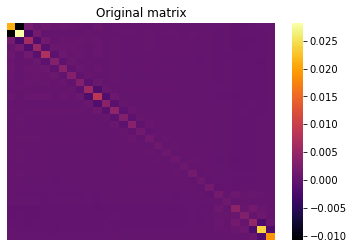

In [2]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)
scaler_sys = StandardScaler()
scaler_sys.fit(syscov)
syscov = scaler_sys.transform(syscov)
print(np.min(syscov), np.max(syscov), np.mean(syscov))
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(syscov)), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix')

In [3]:
def permutMatrix(omatrix, nmatrix):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
        matrixset[it, :, :] = p
    return matrixset


In [4]:
import math

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

### Generate a data set with covariance matrix from the original plus gaussian noise

In [5]:
magnitudes = matrixMag(syscov)

In [6]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))
permMatrix = permutMatrix(syscov, numMatrix)
print(np.shape(permMatrix))

(1000, 31, 31)


In [7]:
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    for row in range(nsize):
        for col in range(nsize):
            if row == col:
                err = np.random.rand()
                covset[i, row, col] = permMatrix[i, row, col] + 1e-4*err*magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col] + 1e-4*err*magnitudes[row, col]
            else:
                covset[i, row, col] = permMatrix[i, row, col] + 0.1*np.random.rand()*magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col]  + np.random.rand()*magnitudes[row, col]

 Generating 512 matrix

 Generating 1000 matrix 

In [8]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

(1000, 31, 31)


Text(0.5, 1.0, 'NOISE MATRIX')

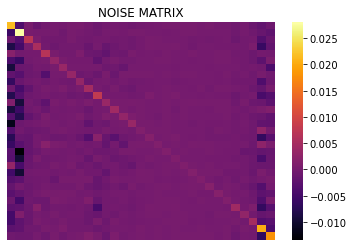

In [9]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_noise_test[0])), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
# sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("NOISE MATRIX")

Text(0.5, 1.0, 'TEST MATRIX')

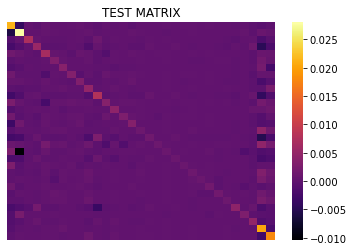

In [10]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_test[0])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")

In [11]:
input_img = tf.keras.Input(shape=(31, 31, 1))

x = layers.ZeroPadding2D(((5,4),(5,4)))(input_img)
x = layers.Conv2D(2, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)
decoded = layers.Cropping2D(cropping=((5, 4), (5, 4)))(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 31, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 2)         52        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 2)         38        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 2)         38    

In [12]:
autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=1000,
                batch_size=128,
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))

Epoch 1/1000
7/7 [==============================] - 1s 94ms/step - loss: 1.0268 - val_loss: 1.0229
Epoch 2/1000
7/7 [==============================] - 0s 46ms/step - loss: 1.0223 - val_loss: 1.0212
Epoch 3/1000
7/7 [==============================] - 0s 44ms/step - loss: 1.0209 - val_loss: 1.0201
Epoch 4/1000
7/7 [==============================] - 0s 45ms/step - loss: 1.0197 - val_loss: 1.0184
Epoch 5/1000
7/7 [==============================] - 0s 45ms/step - loss: 1.0174 - val_loss: 1.0136
Epoch 6/1000
7/7 [==============================] - 0s 46ms/step - loss: 1.0110 - val_loss: 1.0021
Epoch 7/1000
7/7 [==============================] - 0s 45ms/step - loss: 0.9979 - val_loss: 0.9832
Epoch 8/1000
7/7 [==============================] - 0s 45ms/step - loss: 0.9761 - val_loss: 0.9499
Epoch 9/1000
7/7 [==============================] - 0s 47ms/step - loss: 0.9381 - val_loss: 0.8974
Epoch 10/1000
7/7 [==============================] - 0s 47ms/step - loss: 0.8856 - val_loss: 0.8593
Epoch 11/

7/7 [==============================] - 0s 44ms/step - loss: 0.2600 - val_loss: 0.2606
Epoch 84/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2601 - val_loss: 0.2598
Epoch 85/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2595 - val_loss: 0.2589
Epoch 86/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2592 - val_loss: 0.2594
Epoch 87/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2594 - val_loss: 0.2580
Epoch 88/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2577 - val_loss: 0.2574
Epoch 89/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2581 - val_loss: 0.2577
Epoch 90/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2568 - val_loss: 0.2553
Epoch 91/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2555 - val_loss: 0.2552
Epoch 92/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2549 - val_loss: 0.2541
Epoch 93/1000


7/7 [==============================] - 0s 44ms/step - loss: 0.2352 - val_loss: 0.2349
Epoch 165/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2349 - val_loss: 0.2354
Epoch 166/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2352 - val_loss: 0.2351
Epoch 167/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2352 - val_loss: 0.2350
Epoch 168/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2345 - val_loss: 0.2362
Epoch 169/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2381 - val_loss: 0.2351
Epoch 170/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2355 - val_loss: 0.2348
Epoch 171/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2351 - val_loss: 0.2341
Epoch 172/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2344 - val_loss: 0.2350
Epoch 173/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2359 - val_loss: 0.2342
Epoch

7/7 [==============================] - 0s 43ms/step - loss: 0.2310 - val_loss: 0.2299
Epoch 246/1000
7/7 [==============================] - 0s 45ms/step - loss: 0.2293 - val_loss: 0.2294
Epoch 247/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2289 - val_loss: 0.2308
Epoch 248/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2328 - val_loss: 0.2292
Epoch 249/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2288 - val_loss: 0.2287
Epoch 250/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2282 - val_loss: 0.2289
Epoch 251/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2284 - val_loss: 0.2293
Epoch 252/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2284 - val_loss: 0.2336
Epoch 253/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2371 - val_loss: 0.2328
Epoch 254/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2321 - val_loss: 0.2286
Epoch

7/7 [==============================] - 0s 43ms/step - loss: 0.2279 - val_loss: 0.2260
Epoch 327/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2266 - val_loss: 0.2257
Epoch 328/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2264 - val_loss: 0.2298
Epoch 329/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2277 - val_loss: 0.2280
Epoch 330/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2268 - val_loss: 0.2250
Epoch 331/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2254 - val_loss: 0.2280
Epoch 332/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2272 - val_loss: 0.2285
Epoch 333/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2267 - val_loss: 0.2256
Epoch 334/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2251 - val_loss: 0.2251
Epoch 335/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2243 - val_loss: 0.2252
Epoch

7/7 [==============================] - 0s 45ms/step - loss: 0.2255 - val_loss: 0.2250
Epoch 408/1000
7/7 [==============================] - 0s 45ms/step - loss: 0.2236 - val_loss: 0.2224
Epoch 409/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2228 - val_loss: 0.2269
Epoch 410/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2245 - val_loss: 0.2244
Epoch 411/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2229 - val_loss: 0.2227
Epoch 412/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2226 - val_loss: 0.2272
Epoch 413/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2244 - val_loss: 0.2318
Epoch 414/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2275 - val_loss: 0.2233
Epoch 415/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2233 - val_loss: 0.2232
Epoch 416/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2230 - val_loss: 0.2230
Epoch

7/7 [==============================] - 0s 43ms/step - loss: 0.2210 - val_loss: 0.2224
Epoch 489/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2211 - val_loss: 0.2267
Epoch 490/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2240 - val_loss: 0.2232
Epoch 491/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2208 - val_loss: 0.2203
Epoch 492/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2205 - val_loss: 0.2202
Epoch 493/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2207 - val_loss: 0.2218
Epoch 494/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2214 - val_loss: 0.2228
Epoch 495/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2213 - val_loss: 0.2213
Epoch 496/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2209 - val_loss: 0.2208
Epoch 497/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2198 - val_loss: 0.2210
Epoch

7/7 [==============================] - 0s 43ms/step - loss: 0.2194 - val_loss: 0.2189
Epoch 570/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2190 - val_loss: 0.2199
Epoch 571/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2182 - val_loss: 0.2182
Epoch 572/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2174 - val_loss: 0.2181
Epoch 573/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2175 - val_loss: 0.2181
Epoch 574/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2196 - val_loss: 0.2248
Epoch 575/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2211 - val_loss: 0.2186
Epoch 576/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2186 - val_loss: 0.2186
Epoch 577/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2198 - val_loss: 0.2186
Epoch 578/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2179 - val_loss: 0.2175
Epoch

7/7 [==============================] - 0s 43ms/step - loss: 0.2219 - val_loss: 0.2157
Epoch 651/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2168 - val_loss: 0.2172
Epoch 652/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2168 - val_loss: 0.2179
Epoch 653/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2168 - val_loss: 0.2186
Epoch 654/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2167 - val_loss: 0.2160
Epoch 655/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2160 - val_loss: 0.2171
Epoch 656/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2157 - val_loss: 0.2153
Epoch 657/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2149 - val_loss: 0.2154
Epoch 658/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2148 - val_loss: 0.2161
Epoch 659/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2173 - val_loss: 0.2228
Epoch

7/7 [==============================] - 0s 43ms/step - loss: 0.2142 - val_loss: 0.2141
Epoch 732/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2150 - val_loss: 0.2155
Epoch 733/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2147 - val_loss: 0.2153
Epoch 734/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2144 - val_loss: 0.2147
Epoch 735/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2158 - val_loss: 0.2169
Epoch 736/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2151 - val_loss: 0.2144
Epoch 737/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2138 - val_loss: 0.2139
Epoch 738/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2139 - val_loss: 0.2218
Epoch 739/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2215 - val_loss: 0.2149
Epoch 740/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2158 - val_loss: 0.2140
Epoch

7/7 [==============================] - 0s 43ms/step - loss: 0.2145 - val_loss: 0.2166
Epoch 813/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2150 - val_loss: 0.2202
Epoch 814/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2174 - val_loss: 0.2157
Epoch 815/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2140 - val_loss: 0.2137
Epoch 816/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2132 - val_loss: 0.2139
Epoch 817/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2134 - val_loss: 0.2152
Epoch 818/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2140 - val_loss: 0.2147
Epoch 819/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2138 - val_loss: 0.2201
Epoch 820/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2179 - val_loss: 0.2167
Epoch 821/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2160 - val_loss: 0.2155
Epoch

7/7 [==============================] - 0s 44ms/step - loss: 0.2132 - val_loss: 0.2126
Epoch 894/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2140 - val_loss: 0.2127
Epoch 895/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2136 - val_loss: 0.2127
Epoch 896/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2131 - val_loss: 0.2125
Epoch 897/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2125 - val_loss: 0.2145
Epoch 898/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2134 - val_loss: 0.2164
Epoch 899/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2144 - val_loss: 0.2164
Epoch 900/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2147 - val_loss: 0.2183
Epoch 901/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2208 - val_loss: 0.2203
Epoch 902/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2189 - val_loss: 0.2153
Epoch

7/7 [==============================] - 0s 44ms/step - loss: 0.2143 - val_loss: 0.2140
Epoch 975/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2133 - val_loss: 0.2146
Epoch 976/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2143 - val_loss: 0.2136
Epoch 977/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2136 - val_loss: 0.2129
Epoch 978/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2136 - val_loss: 0.2121
Epoch 979/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2129 - val_loss: 0.2181
Epoch 980/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2153 - val_loss: 0.2148
Epoch 981/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.2140 - val_loss: 0.2137
Epoch 982/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.2127 - val_loss: 0.2135
Epoch 983/1000
7/7 [==============================] - 0s 42ms/step - loss: 0.2132 - val_loss: 0.2131
Epoch

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

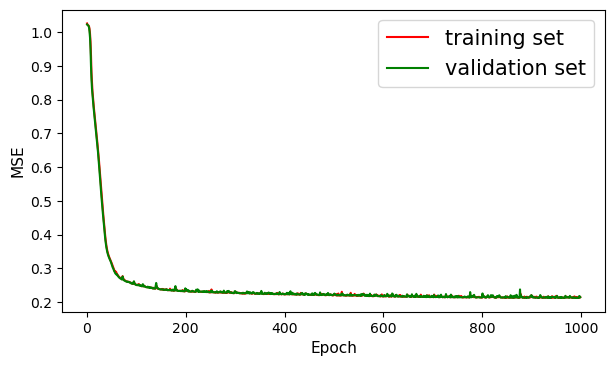

In [13]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [14]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

0.21203260123729709 0.21178920567035675


In [15]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

Text(0.5, 1.0, 'Test noise matrix')

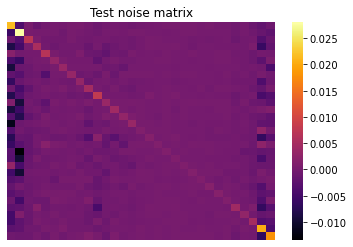

In [16]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_noise_test[0])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Test noise matrix')

(200, 31, 31)


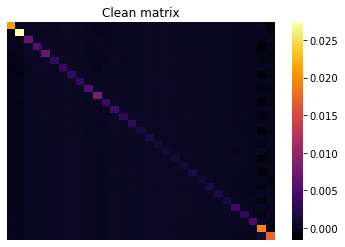

In [17]:
clean_img = autoencoder.predict(covset_noise_test)

print(np.shape(covset_noise_test))
clean_imgr = scaler_sys.inverse_transform(clean_img[0].reshape(31,31))

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Clean matrix')

np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")

Text(0.5, 1.0, 'Clean matrix 2')

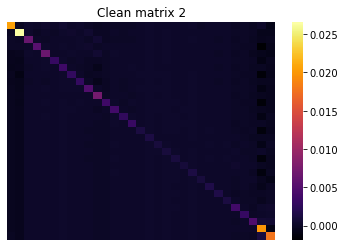

In [18]:
clean_img = autoencoder.predict(clean_img)

clean_imgr = scaler_sys.inverse_transform(clean_img[0].reshape(31,31))

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Clean matrix 2')

Text(0.5, 1.0, 'Filled matrix')

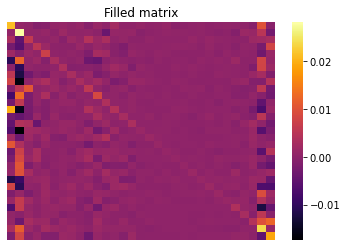

In [19]:
filled_matrix = np.zeros((nsize, nsize))
for row in range(nsize):
    for col in range(nsize):
        if row == col:
#             err = np.random.randn()
            filled_matrix[row, col] = syscov[row, col] 
#     + 0.1*err*magnitudes[row, col]
        else:
            err = np.random.randn()
            filled_matrix[row, col] = err*magnitudes[row, col]

sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(filled_matrix)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Filled matrix')

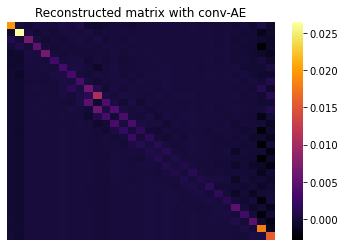

In [20]:
# filled_matrix = scaler_sys.transform(filled_matrix).reshape(1,31,31,1)

clean_img = autoencoder.predict(filled_matrix.reshape(1,31,31,1))

clean_imgr = scaler_sys.inverse_transform(clean_img[0,:,:,0])

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Reconstructed matrix with conv-AE')
plt.savefig('rec_matrix_conv_vae.png')

In [21]:
# np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")

In [22]:
# autoencoder.save('../models/autoencoderCONV_JLA.h5')
# decoder.save('../models/decoderJLA.h5')
# encoder.save('../models/encoderJLA.h5')